#Streaming Data Management and Time Series Analysis

Master's Degree in Data Science (A.Y. 2021/2022)

Times Series univariata

Author:Ranieri Silvia | 878067 | s.ranieri7@campus.unimib.it

#Librerie

In [1]:
!pip install pmdarima

In [2]:
!pip install keras

In [3]:
!pip install tensorflow

In [4]:
!pip install statsmodels

In [5]:
import numpy as np
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns 
import math
import glob
import os
np.random.seed(1028) 
# per score fitting
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

import pmdarima

# time series analysis
import pickle
from statsmodels.tsa.statespace.sarimax import SARIMAX
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf #per me non servono!!
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.deterministic import DeterministicProcess

#machine learnig
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

#Funzioni


In [6]:
def adf_test(timeseries):
  print ('Results of Dickey-Fuller Test:')
  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value
  print (dfoutput)

In [7]:
def kpss_test(timeseries):
  print ('Results of KPSS Test:')
  kpsstest = kpss(timeseries, regression='c')
  kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
  for key,value in kpsstest[3].items():
      kpss_output['Critical Value (%s)'%key] = value
  print (kpss_output)

In [8]:
def mape_test(test, pred): 
    test, pred = np.array(test), np.array(pred)
    return np.mean(np.abs((test - pred) / test)) * 100

In [9]:
def mape_train(train, pred): 
    train, pred = np.array(train), np.array(pred)
    return np.mean(np.abs((train - pred) / train)) * 100

In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
#Mean Absolute Error 
def mean_absolute_error(y_true, y_pred): 
  return round(np.mean(np.abs(y_true - y_pred)), 1)

In [12]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [13]:

def decompose(df, column_name):
    """
    A function that returns the trend, seasonality and residual captured by applying both multiplicative and
    additive model.
    df -> DataFrame
    column_name -> column_name for which trend, seasonality is to be captured
    """
    result_mul = seasonal_decompose(df[column_name], model='multiplicative', extrapolate_trend = 'freq')
    result_add = seasonal_decompose(df[column_name], model = 'additive', extrapolate_trend='freq')

    plt.rcParams.update({'figure.figsize': (20, 10)})
    result_mul.plot().suptitle('Multiplicative Decompose', fontsize=30)
    result_add.plot().suptitle('Additive Decompose', fontsize=30)
    plt.show()
    
    return result_mul, result_add

In [14]:
def acf_pacf_plot(model):
    plt.rcParams.update({'figure.figsize':(12,4)})
    residuals = pd.DataFrame(model.resid)
    fig1, axes1 = plt.subplots(1, 2, sharex=True)
    plot_acf(residuals, lags=400, ax=axes1[0]); axes1[0].set_title('ACF')
    plot_pacf(residuals, lags=400, ax=axes1[1]); axes1[1].set_title('PACF'); axes1[1].set_title('PACF')
    plt.show()
    residuals.describe()

#Importazione dati

In [15]:
df = pd.read_csv('/Users/silviaranieri/Desktop/Project_data_2021_2022 (TRAINSET).csv')
print(df)

            Date  Hour      CO
0     2004-03-10    18  1360.0
1     2004-03-10    19  1292.0
2     2004-03-10    20  1402.0
3     2004-03-10    21  1376.0
4     2004-03-10    22  1272.0
...          ...   ...     ...
8521  2005-02-28    19   938.0
8522  2005-02-28    20   939.0
8523  2005-02-28    21   827.0
8524  2005-02-28    22   776.0
8525  2005-02-28    23   755.0

[8526 rows x 3 columns]


In [16]:
df['Hour']=df['Hour'].astype(str)
#trasform into datetime object
df['Date_Hour']=pd.to_datetime(df['Date']+'-'+df['Hour'],  format = "%Y-%m-%d-%H" )
#delete the columns that are no longer needed
df.drop(['Date', 'Hour'], axis='columns', inplace=True)

In [17]:
#check that there are no missing dates within the dataset.
#Transform the datatime column (containing date and time) into index by also inserting the missing dates
r = pd.date_range(start=df['Date_Hour'].min(), end=df['Date_Hour'].max(), freq='H')
df.set_index('Date_Hour', inplace=True)
df=df.reindex(r)
df.index.rename('Date_Hour', inplace=True)

In [18]:
#missing dates
df.index[df['CO'].isnull()]

DatetimeIndex(['2004-04-01 14:00:00', '2004-04-01 15:00:00',
               '2004-04-01 16:00:00', '2004-04-08 23:00:00',
               '2004-04-09 00:00:00', '2004-04-09 01:00:00',
               '2004-04-09 02:00:00', '2004-04-09 03:00:00',
               '2004-04-09 04:00:00', '2004-04-09 05:00:00',
               ...
               '2005-02-11 11:00:00', '2005-02-11 12:00:00',
               '2005-02-11 13:00:00', '2005-02-11 14:00:00',
               '2005-02-11 15:00:00', '2005-02-11 16:00:00',
               '2005-02-11 17:00:00', '2005-02-11 18:00:00',
               '2005-02-11 19:00:00', '2005-02-11 20:00:00'],
              dtype='datetime64[ns]', name='Date_Hour', length=365, freq=None)

<AxesSubplot:xlabel='Date_Hour'>

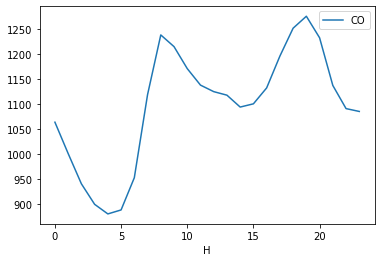

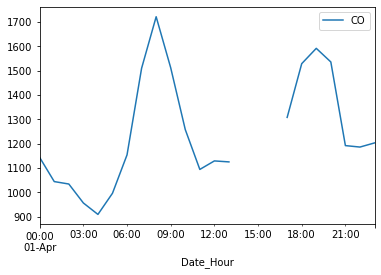

In [19]:
serie= df[['CO']]
serie['H'] = serie.index.hour
serie.groupby('H').mean().plot()
df.loc['2004-04-01'].plot()

Correzione dati mancanti

In [20]:

d = 7
for ind in df.index[df['CO'].isnull()]:
  new_range = df.loc[ind-datetime.timedelta(days=d):ind+datetime.timedelta(days=d)]
  new_range = new_range[new_range.index.hour == ind.hour]
  new_value = new_range.mean()
  df.loc[ind]['CO'] = new_value

In [21]:
print(df['CO'].isnull().sum())


0


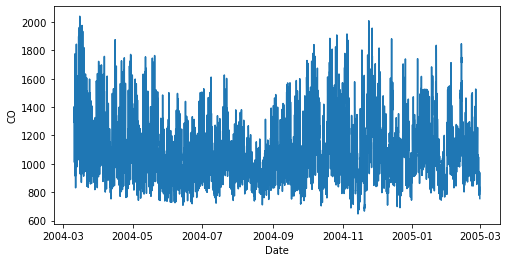

In [22]:
plt.figure(figsize=(8,4))
plt.xlabel('Date')
plt.ylabel('CO')
plt.plot(df)

variazioni più alte che sembrano ripetersi nei mesi invernali.

Andamento di dei mesi estivi

In [23]:
tre_mesi = df.loc['2004-06-01':'2004-09-01']
tre_mesi


,CO
Date_Hour,
2004-06-01 00:00:00,922.0
2004-06-01 01:00:00,830.0
2004-06-01 02:00:00,805.0
2004-06-01 03:00:00,760.0
2004-06-01 04:00:00,783.0
...,...
2004-09-01 19:00:00,1261.0
2004-09-01 20:00:00,1093.0
2004-09-01 21:00:00,1068.0


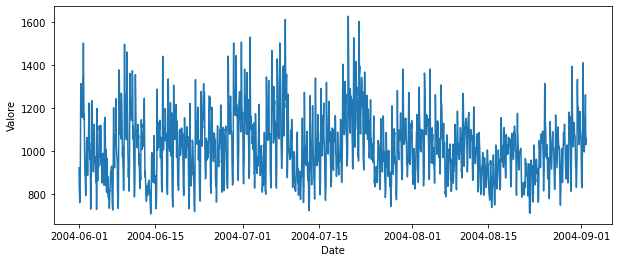

In [24]:
plt.figure(figsize=(10,4))
plt.xlabel('Date')
plt.ylabel('Valore')
plt.plot(tre_mesi)



In [25]:
df['Year']=df.index.year
df['Month']=df.index.month
df['Dayofweek']=df.index.day_name()
df['Day']=df.index.day
df['Hour']=df.index.hour

In [26]:
df

,CO,Year,Month,Dayofweek,Day,Hour
Date_Hour,,,,,,
2004-03-10 18:00:00,1360.0,2004,3,Wednesday,10,18
2004-03-10 19:00:00,1292.0,2004,3,Wednesday,10,19
2004-03-10 20:00:00,1402.0,2004,3,Wednesday,10,20
2004-03-10 21:00:00,1376.0,2004,3,Wednesday,10,21
2004-03-10 22:00:00,1272.0,2004,3,Wednesday,10,22
...,...,...,...,...,...,...
2005-02-28 19:00:00,938.0,2005,2,Monday,28,19
2005-02-28 20:00:00,939.0,2005,2,Monday,28,20
2005-02-28 21:00:00,827.0,2005,2,Monday,28,21


#Analisi del consumo medio per giorno della settimana

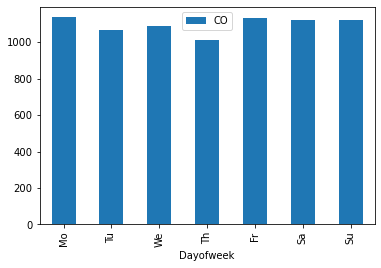

In [27]:
# etichetta per visualizzazione negli assi
weekday_labels = ['Mo','Tu','We','Th','Fr','Sa','Su']

# raggruppo i dati per giorno della settimana e ne calcolo la media del consumo
ax = df[['Dayofweek', 'CO']].groupby(['Dayofweek']).mean().plot(kind = 'bar')

# Visualizzo il nome dei giorni sull'etichetta
# (semicolon finale per prevenire il printing della lista)
ax.set_xticklabels(weekday_labels);

#Analisi del consumo medio per mese

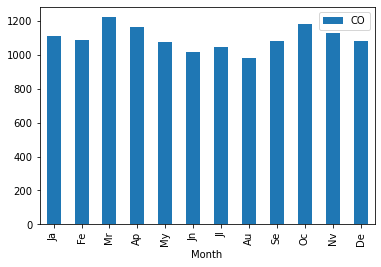

In [28]:
# etichetta per visualizzazione negli assi
month_labels = ['Ja','Fe','Mr','Ap','My','Jn','Jl','Au','Se','Oc','Nv','De']

# raggruppo i dati per mese e calcolo la media del consumo
ax = df[['Month', 'CO']].groupby(['Month']).mean().plot(kind = 'bar')

# Visualizzo il nome dei giorni sull'etichetta
# (semicolon finale per prevenire il printing della lista)
ax.set_xticklabels(month_labels);

#Analisi del consumo medio per anno



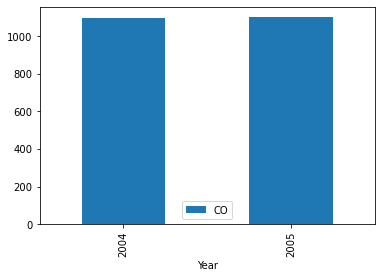

In [29]:
# raggruppo i dati per anno e calcolo la media del consumo
df_difference_temp = df[['Year', 'CO']].groupby(['Year']).mean()

# Visualizzo il grafico
df_difference_temp.plot(kind = 'bar');

/Applications/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


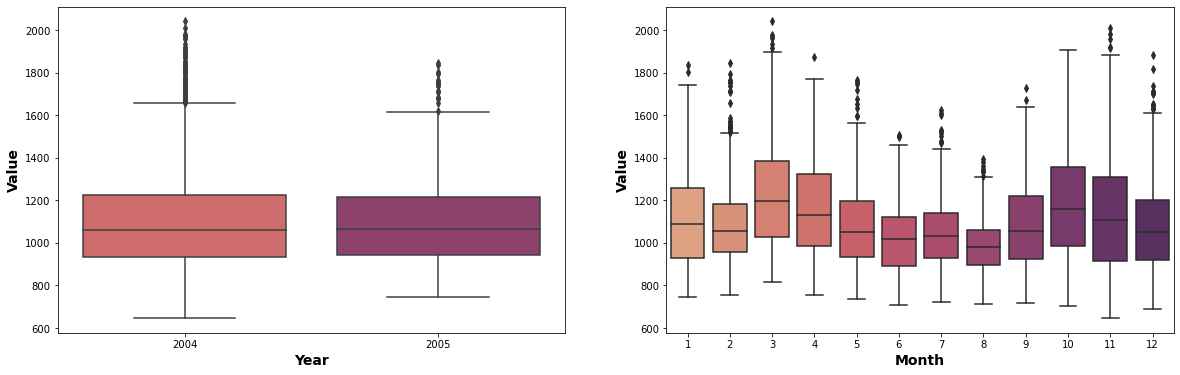

In [30]:
#Box-Plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

sns.boxplot(df['Year'], df['CO'], ax=ax[0], palette='flare')
ax[0].set_xlabel('Year', fontsize = 14, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Value', fontsize = 14, fontdict=dict(weight='bold'))


sns.boxplot(df['Month'], df['CO'], ax=ax[1], palette='flare')
ax[1].set_xlabel('Month', fontsize = 14, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Value', fontsize = 14, fontdict=dict(weight='bold'))
plt.show()

#Analisi consumo medio per ora giorno della settimana

/Applications/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


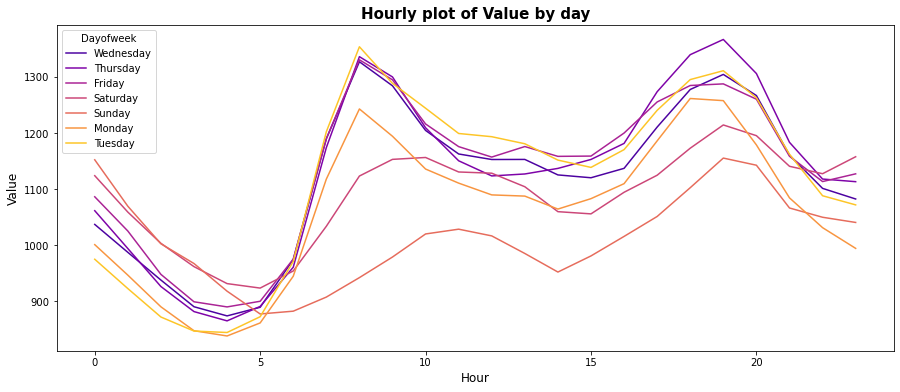

In [31]:
plt.figure(figsize=(15, 6))
sns.lineplot(df['Hour'], df['CO'], hue=df['Dayofweek'], ci=None, palette="plasma")
plt.title('Hourly plot of Value by day', fontsize = 15, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Hour', fontsize = 12)
plt.ylabel('Value', fontsize = 12)
plt.show()

#Analisi consumo medio per ora giorno del mese

/Applications/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


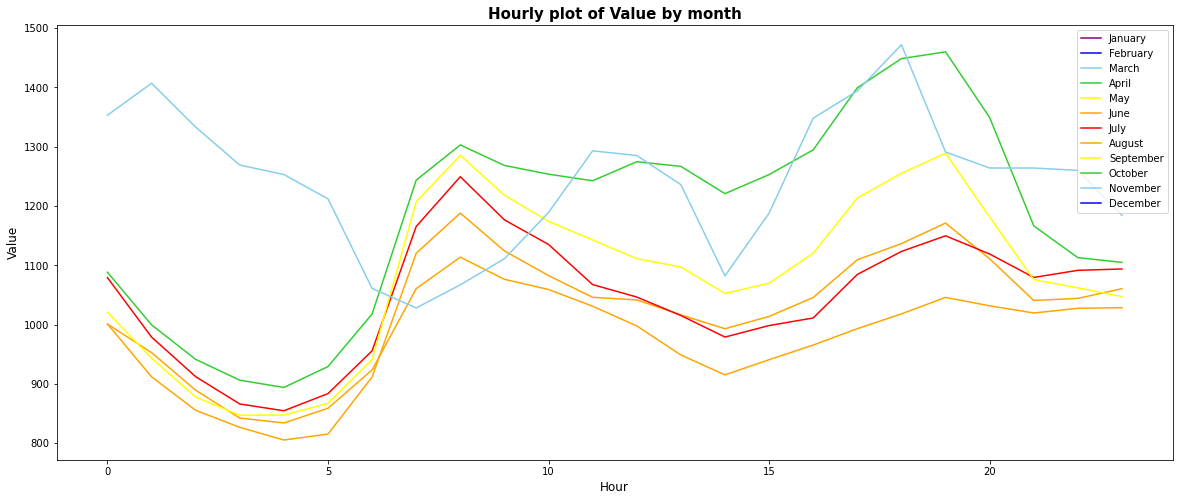

In [32]:
plt.figure(figsize=(20, 8))
sns.lineplot(df.loc["2004-06-01 00:00:00":"2004-11-01 23:00:00"]['Hour'], df['CO'], hue=df['Month'], ci=None, 
             palette=["purple","blue","skyblue","limegreen","yellow","orange","red","orange","yellow","limegreen","skyblue","blue"])
plt.title('Hourly plot of Value by month', fontsize = 15, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Hour', fontsize = 12)
plt.ylabel('Value', fontsize = 12)
plt.legend(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.show()

In [33]:
df=df.drop(df.loc[:,'Year':'Hour'].columns, axis = 1)

In [34]:
df

,CO
Date_Hour,
2004-03-10 18:00:00,1360.0
2004-03-10 19:00:00,1292.0
2004-03-10 20:00:00,1402.0
2004-03-10 21:00:00,1376.0
2004-03-10 22:00:00,1272.0
...,...
2005-02-28 19:00:00,938.0
2005-02-28 20:00:00,939.0
2005-02-28 21:00:00,827.0


#Train e test set

In [35]:
from dateutil.relativedelta import relativedelta
relativedelta(df.index[-1],df.index[0]) #range intero dataset

relativedelta(months=+11, days=+18, hours=+5)

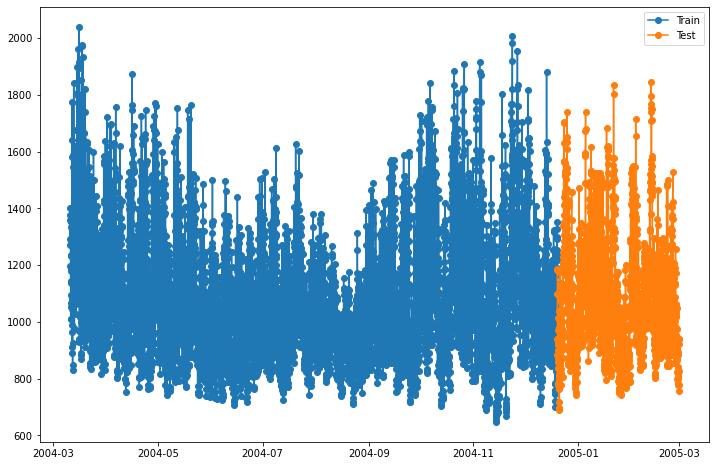

In [36]:
# Train Test Split Index
train_size = 0.8
split_idx = round(len(df)* train_size)
split_idx

# Split
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(train, label='Train', **kws)
plt.plot(test, label='Test', **kws)
ax.legend(bbox_to_anchor=[1,1]);

In [37]:
#extracting daily seasonality from raw time series
sd_24 = sm.tsa.seasonal_decompose(train, period=24)

#extracting weekly seasonality from time series adjusted by daily seasonality
sd_168 = sm.tsa.seasonal_decompose(train - np.array(sd_24.seasonal).reshape(-1,1), period=168)

#extracting yearly seasonality from time series adjusted by daily and weekly seasonality
#sd_8766 = sm.tsa.seasonal_decompose(train - np.array(sd_168.seasonal).reshape(-1,1), period=8766)

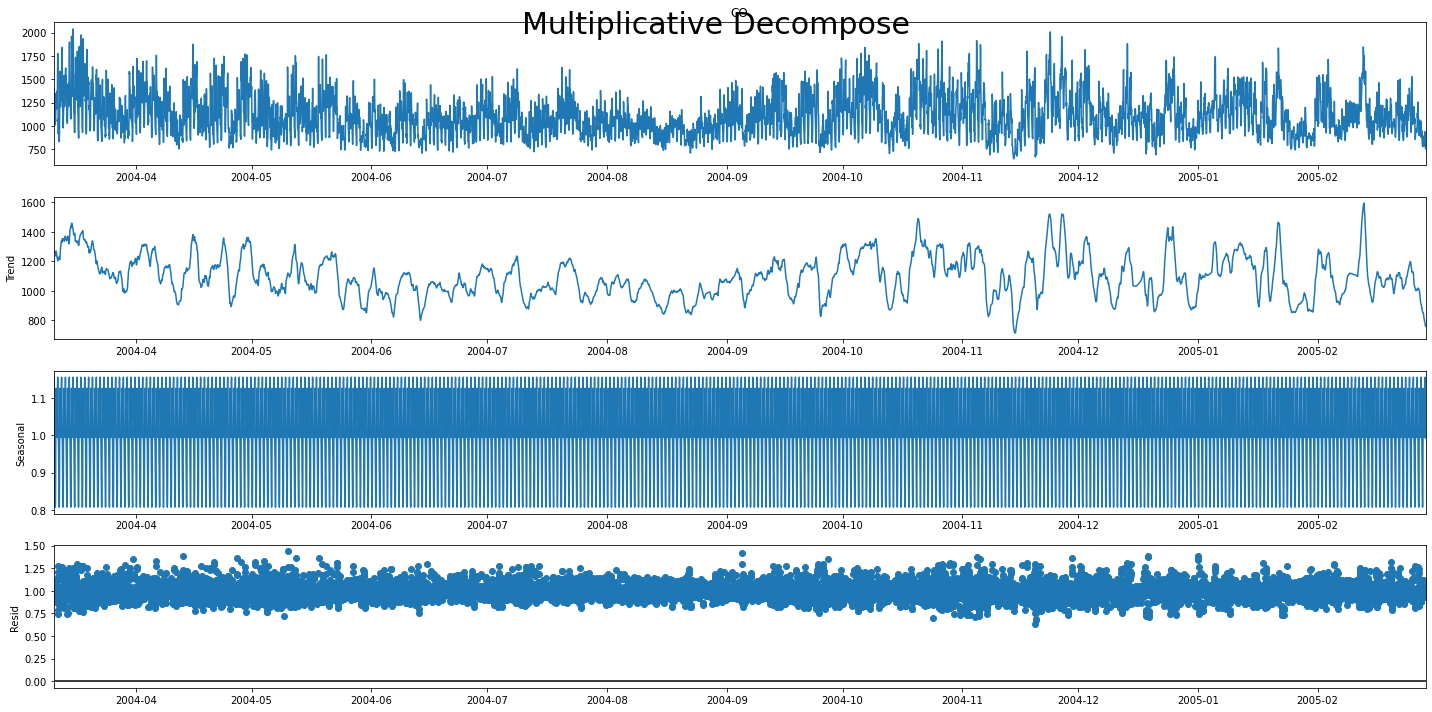

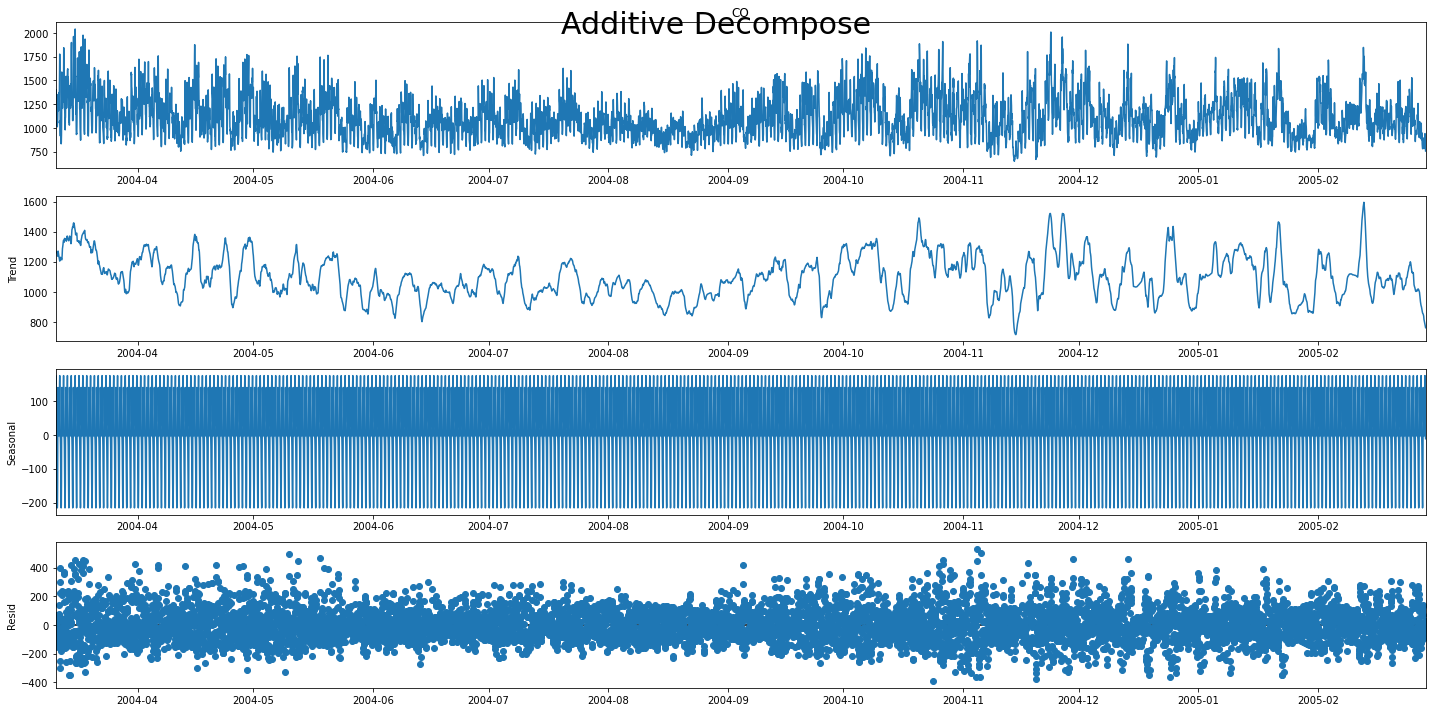

In [38]:
result_mul, result_add = decompose(df, 'CO')

#Stazionarietà

In [39]:
adf_test(train['CO'])

Results of Dickey-Fuller Test:
Test Statistic                -7.903959e+00
p-value                        4.113916e-12
Lags Used                      3.200000e+01
Number of Observations Used    6.788000e+03
Critical Value (1%)           -3.431314e+00
Critical Value (5%)           -2.861966e+00
Critical Value (10%)          -2.566997e+00
dtype: float64


In [40]:
kpss_test(df['CO'])

Results of KPSS Test:
Test Statistic            0.553925
p-value                   0.029522
Lags Used                46.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


p-value > 0.05: l'ipotesi nulla (H0) non può essere rifiutata, i dati hanno una radice unitaria e non sono stazionari.

p-value <= 0,05: rifiuta l'ipotesi nulla (H0), i dati non hanno una radice unitaria e sono stazionari.




Osserviamo che dal dal test ADF la serie è stazionaria mentre per KPSS, la serie è non stazionaria a un livello di significatività del 0.95, perciò è necessario applicare la differenzazione.

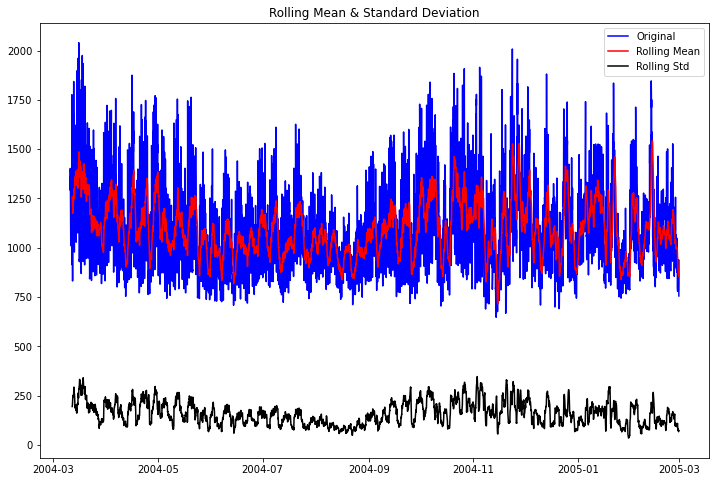

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -9.341903e+00
p-value                        8.751258e-16
#Lags Used                     3.700000e+01
Number of Observations Used    8.488000e+03
Critical Value (1%)           -3.431121e+00
Critical Value (5%)           -2.861881e+00
Critical Value (10%)          -2.566951e+00
dtype: float64


In [41]:
# determino se la serie è stazionaria o no
def test_stationarity(timeseries, window = 30, cutoff = 0.01):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    X = df['CO']
    print('Results of Dickey-Fuller Test:')
    dftest =adfuller(X)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
  

    print(dfoutput)
    
test_stationarity(df)

#Differenzazione

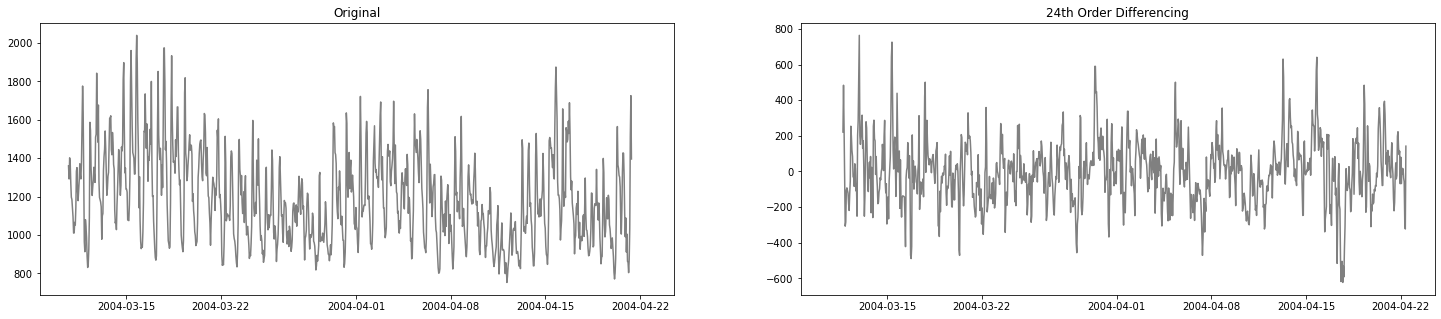

In [42]:
plt.rcParams.update({'figure.figsize':(25,5)})
fig0, axes0 = plt.subplots(1, 2, sharex=True)

axes0[0].plot(train['CO'][:1000], color = 'gray')
axes0[0].set_title('Original')

axes0[1].plot(train['CO'].diff(24).dropna()[:1000], color = 'gray');
axes0[1].set_title('24th Order Differencing')
plt.show()

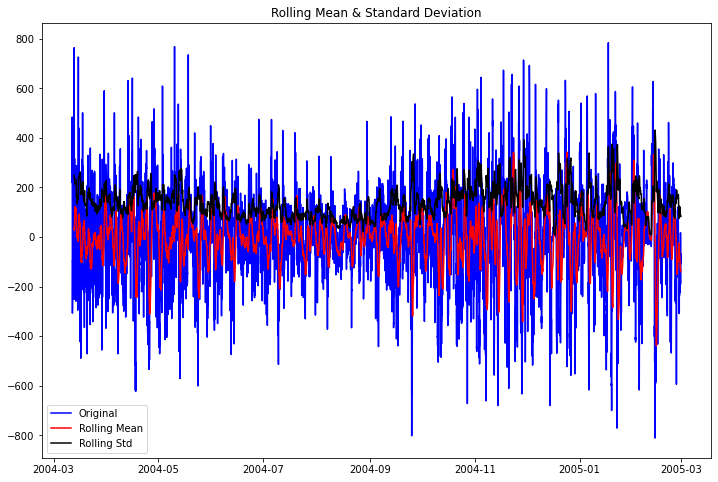

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -9.341903e+00
p-value                        8.751258e-16
#Lags Used                     3.700000e+01
Number of Observations Used    8.488000e+03
Critical Value (1%)           -3.431121e+00
Critical Value (5%)           -2.861881e+00
Critical Value (10%)          -2.566951e+00
dtype: float64


In [43]:
df_diff = df - df.shift(24)
df_diff.dropna(inplace=True)
test_stationarity(df_diff)

#Grafico ACF PACF

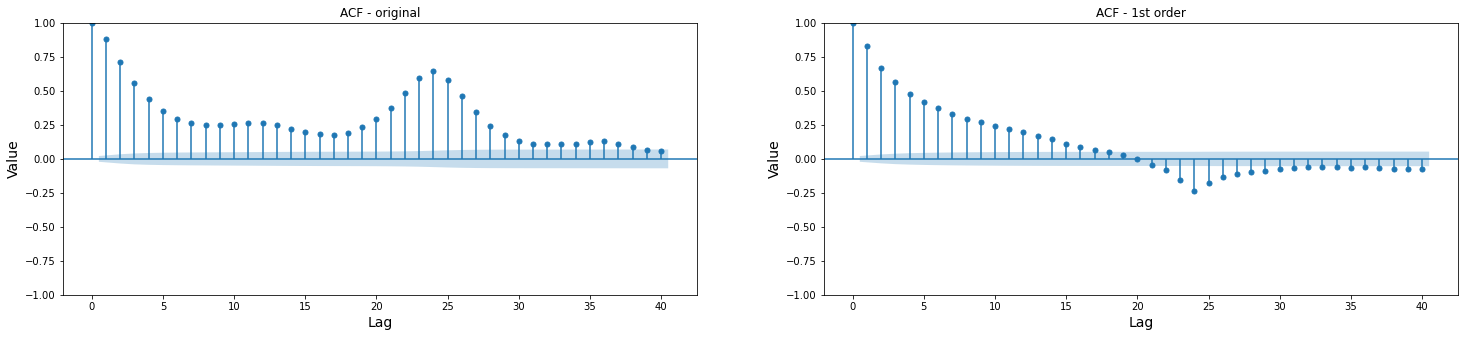

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


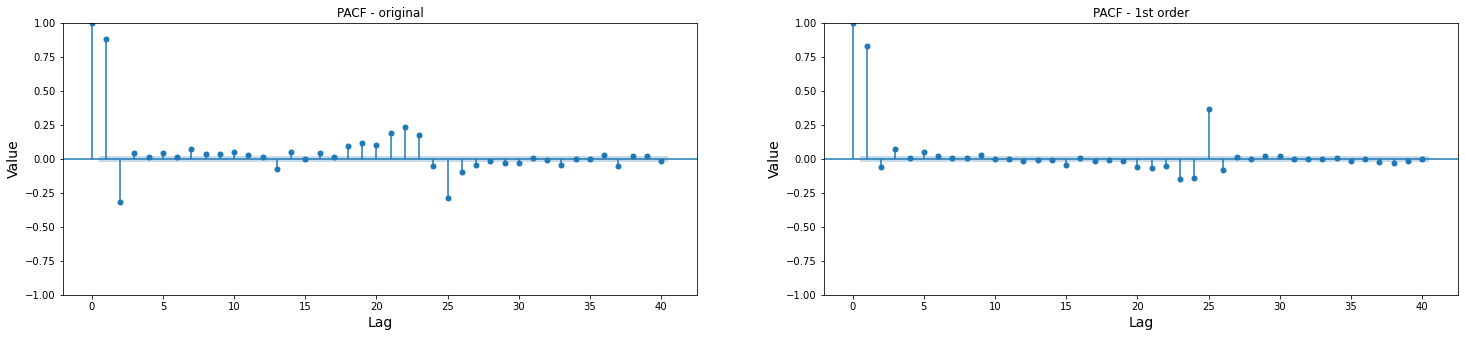

In [44]:
# Original Series
fig1, axes1 = plt.subplots(1, 2, sharex=True)
plot_acf(df['CO'], ax=axes1[0]); axes1[0].set_title('ACF - original')
axes1[0].set_xlabel('Lag', fontsize = 14)
axes1[0].set_ylabel('Value', fontsize = 14)
# 1st Differencing
plot_acf(df['CO'].diff(24).dropna(), ax=axes1[1]); axes1[1].set_title('ACF - 1st order')
axes1[1].set_xlabel('Lag', fontsize = 14)
axes1[1].set_ylabel('Value', fontsize = 14)
plt.show()

fig2, axes2 = plt.subplots(1, 2, sharex=True)
plot_pacf(df['CO'], ax=axes2[0]); axes2[0].set_title('PACF - original')
axes2[0].set_xlabel('Lag', fontsize = 14)
axes2[0].set_ylabel('Value', fontsize = 14)
# 1st Differencing
plot_pacf(df['CO'].diff(24).dropna(), ax=axes2[1]); axes2[1].set_title('PACF - 1st order')
axes2[1].set_xlabel('Lag', fontsize = 14)
axes2[1].set_ylabel('Value', fontsize = 14)
plt.show()

Come mostra il plot dell'ACF, i dati presentano una stagionalità ogni 24 ore.

Il grafico 'PACF - 24 Order Diff' mostra un possibile ordine p=1 o p=2, P=1, Q=1.

#Autoarima

In [45]:
import pmdarima as pm
arima_model = pm.auto_arima(train,start_P=0,d=1,start_q=0,max_p=5,
                            start_p=0,D=1,start_Q=0,max_P=5,max_D=5,
                            max_Q=5,m=24,seasonal=False,error_action='warn',trace=True,
                            suppress_warnings=True,stepwise=True,random_state=20
                            )
print(arima_model.summary())

/Applications/anaconda3/lib/python3.9/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (24) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=83087.131, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=82648.529, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=82565.945, Time=0.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=83085.131, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=82566.091, Time=0.71 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=82564.412, Time=1.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=81848.649, Time=3.58 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=81737.189, Time=4.57 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=81735.839, Time=2.80 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=82510.192, Time=0.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=81737.334, Time=3.52 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=82442.120, Time=0.43 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=81739.837, Time=3.61 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=81733.874, Time=1.08 sec
 ARIMA(1,1,1)(0,0,0

#Modello SARIMAX

In [46]:
mod = sm.tsa.statespace.SARIMAX(train, order=(2,1,1), seasonal_order=(0,0,0,0)) 
model = mod.fit()
print(model.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.02706D+00    |proj g|=  4.78509D-02


 This problem is unconstrained.



At iterate    5    f=  5.99957D+00    |proj g|=  2.91410D-02

At iterate   10    f=  5.99351D+00    |proj g|=  8.81661D-03

At iterate   15    f=  5.99315D+00    |proj g|=  1.69105D-03

At iterate   20    f=  5.99155D+00    |proj g|=  9.40852D-03

At iterate   25    f=  5.99075D+00    |proj g|=  1.63217D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     30      1     0     0   8.037D-06   5.991D+00
  F =   5.9907546051960869     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                               SARIMAX Results                                
Dep. Variable:                    

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


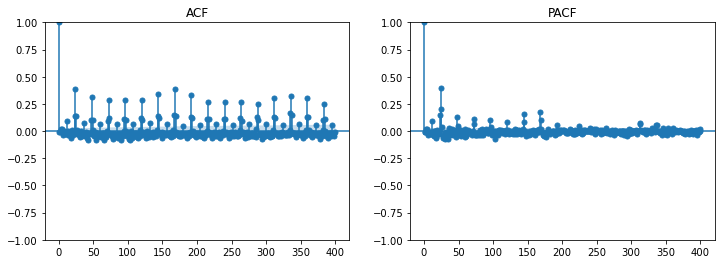

In [47]:
acf_pacf_plot(model)

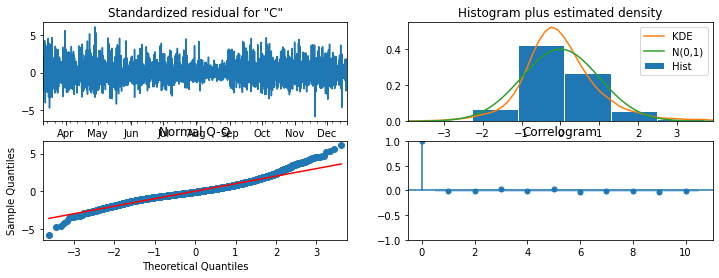

In [48]:
# Visualizzo i grafico di diagnostic
model.plot_diagnostics();

L'ordine Q può essere calcolato dal grafico di autocorrelazione (ACF). L'autocorrelazione è la correlazione di una singola serie temporale con una copia ritardata di se stessa.
Il valore di P può essere estratto osservando il grafico di Autocorrelazione Parziale (PACF) della componente stagionale. PACF può essere immaginato come la correlazione tra la serie e il suo ritardo, dopo aver escluso i contributi dai ritardi intermedi.

In [49]:
mod1 = sm.tsa.statespace.SARIMAX(train, order=(2,1,1), seasonal_order=(1,0,1,24)) 
model1 = mod1.fit()
print(model1.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.91244D+00    |proj g|=  8.63305D-02


 This problem is unconstrained.



At iterate    5    f=  5.86428D+00    |proj g|=  3.49629D-02

At iterate   10    f=  5.84549D+00    |proj g|=  4.58939D-03

At iterate   15    f=  5.81583D+00    |proj g|=  1.01239D-02

At iterate   20    f=  5.80179D+00    |proj g|=  2.98234D-03

At iterate   25    f=  5.79519D+00    |proj g|=  3.82417D-03

At iterate   30    f=  5.79489D+00    |proj g|=  1.69706D-04

At iterate   35    f=  5.79368D+00    |proj g|=  4.45844D-03

At iterate   40    f=  5.79344D+00    |proj g|=  5.05657D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     65      1     0     0   3.047D-05   5.793D+00
  F =   5.79344307507

In [50]:
mod2 = sm.tsa.statespace.SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,1,24)) 
mod2 = mod2.fit()
print(mod2.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.88743D+00    |proj g|=  8.16863D-02

At iterate    5    f=  5.84248D+00    |proj g|=  1.65251D-02

At iterate   10    f=  5.83527D+00    |proj g|=  4.01686D-03

At iterate   15    f=  5.81587D+00    |proj g|=  4.23169D-02

At iterate   20    f=  5.77693D+00    |proj g|=  2.40332D-02

At iterate   25    f=  5.77469D+00    |proj g|=  2.56796D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     31      1     0     0   

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


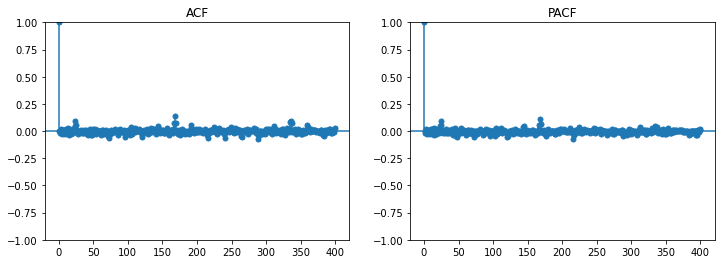

In [51]:
acf_pacf_plot(model1)

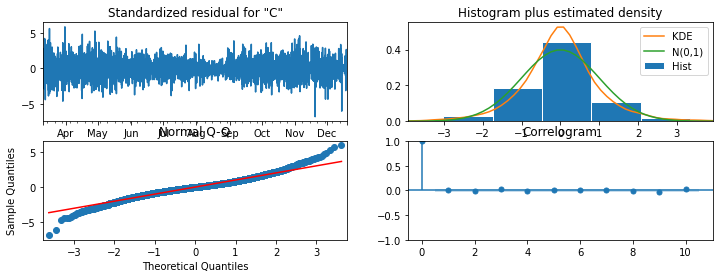

In [52]:
# Visualizzo i grafico di diagnostic
model1.plot_diagnostics();

In [53]:
pred_val = pd.DataFrame(model1.forecast(1705)).set_index(test.index)
pred_train = model1.fittedvalues  

/var/folders/8m/q3zm_4mx7657khdxcx36bp4h0000gn/T/ipykernel_15785/2394299156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_viz['train_fitted'] = pred_train


<AxesSubplot:xlabel='Date_Hour'>

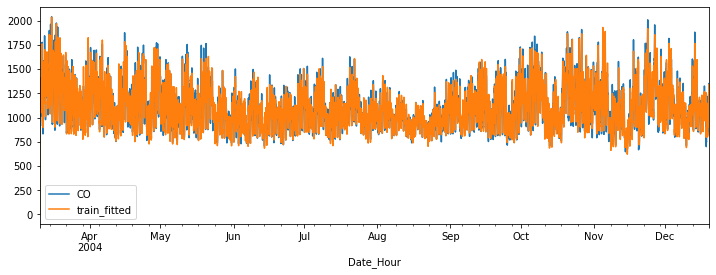

In [54]:
train_viz = train
train_viz['train_fitted'] = pred_train
train_viz[['CO','train_fitted']].plot()

/var/folders/8m/q3zm_4mx7657khdxcx36bp4h0000gn/T/ipykernel_15785/3940056143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_viz['test_fitted'] = pred_val


<AxesSubplot:xlabel='Date_Hour'>

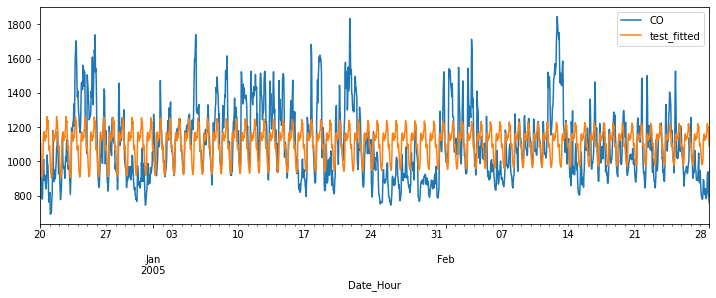

In [55]:
test_viz = test
test_viz['test_fitted'] = pred_val
test_viz[['CO','test_fitted']].plot()

/var/folders/8m/q3zm_4mx7657khdxcx36bp4h0000gn/T/ipykernel_15785/297256772.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


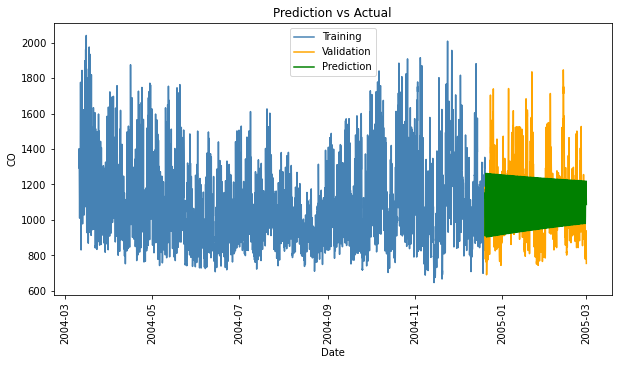

In [56]:
#grafico intero
fig=plt.figure(figsize=(10,5))
fig.show()
ax=fig.add_subplot(111)
plt.title('Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('CO')
plt.xticks(rotation=90)
ax.plot(train_viz['CO'], color='steelblue', label='Training')
#ax.plot(pred_mean_train[1:], color='red')
ax.plot(test_viz['CO'], color='orange', label='Validation')
ax.plot(test_viz['test_fitted'], color='green', label='Prediction')
plt.legend()
plt.show()

In [57]:
y_true_train = train_viz['CO']
y_pred_train = train_viz['train_fitted']
mae_train_SARIMAX= mean_absolute_error(y_true_train, y_pred_train)
mape_train_SARIMAX=  mean_absolute_percentage_error(y_true_train, y_pred_train)
print('MAE_train: %f' % mean_absolute_error(y_true_train, y_pred_train))
print('MAPE_train: %f' % mean_absolute_percentage_error(y_true_train, y_pred_train))
y_true_test = test_viz['CO']
y_pred_test = test_viz['test_fitted']
mae_test_SARIMAX=mean_absolute_error(y_true_test, y_pred_test)
mape_test_SARIMAX=  mean_absolute_percentage_error(y_true_test, y_pred_test)
print('MAE_test: %f'%  mean_absolute_error(y_true_test, y_pred_test))
print('MAPE_test: %f' % mean_absolute_percentage_error(y_true_test, y_pred_test))

MAE_train: 57.800000
MAPE_train: 5.160372
MAE_test: 147.500000
MAPE_test: 13.587774


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


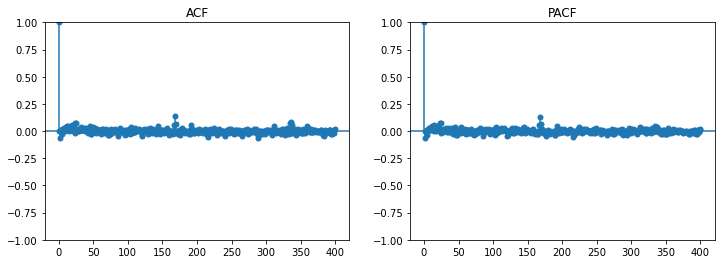

In [58]:
acf_pacf_plot(mod2)

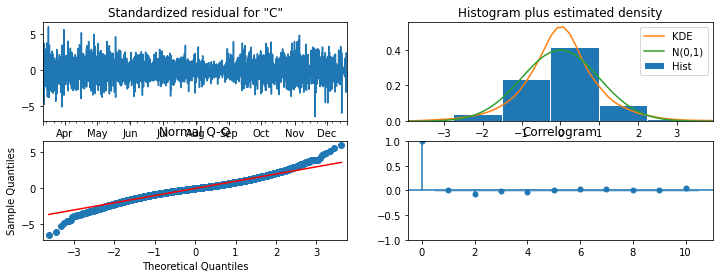

In [59]:
# Visualizzo i grafico di diagnostic
mod2.plot_diagnostics();

In [60]:
pred_val = pd.DataFrame(mod2.forecast(1705)).set_index(test.index)
pred_train = mod2.fittedvalues  

/var/folders/8m/q3zm_4mx7657khdxcx36bp4h0000gn/T/ipykernel_15785/2394299156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_viz['train_fitted'] = pred_train


<AxesSubplot:xlabel='Date_Hour'>

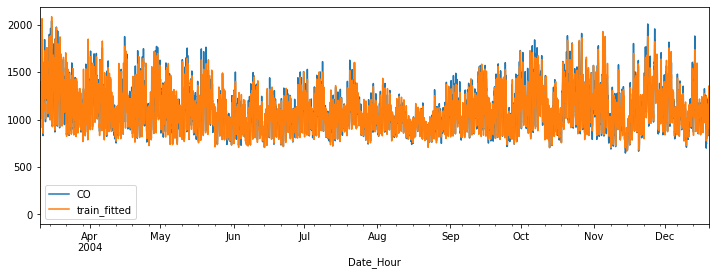

In [61]:
train_viz = train
train_viz['train_fitted'] = pred_train
train_viz[['CO','train_fitted']].plot()

/var/folders/8m/q3zm_4mx7657khdxcx36bp4h0000gn/T/ipykernel_15785/3940056143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_viz['test_fitted'] = pred_val


<AxesSubplot:xlabel='Date_Hour'>

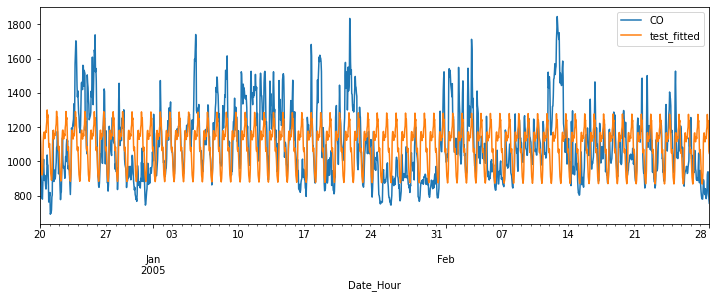

In [62]:
test_viz = test
test_viz['test_fitted'] = pred_val
test_viz[['CO','test_fitted']].plot()

/var/folders/8m/q3zm_4mx7657khdxcx36bp4h0000gn/T/ipykernel_15785/297256772.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


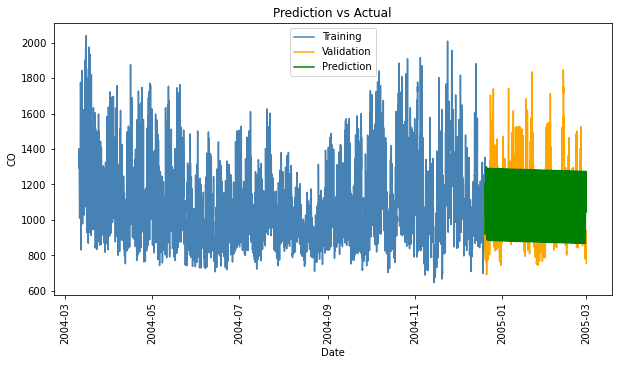

In [63]:
#grafico intero
fig=plt.figure(figsize=(10,5))
fig.show()
ax=fig.add_subplot(111)
plt.title('Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('CO')
plt.xticks(rotation=90)
ax.plot(train_viz['CO'], color='steelblue', label='Training')
#ax.plot(pred_mean_train[1:], color='red')
ax.plot(test_viz['CO'], color='orange', label='Validation')
ax.plot(test_viz['test_fitted'], color='green', label='Prediction')
plt.legend()
plt.show()

In [64]:
y_true_train = train_viz['CO']
y_pred_train = train_viz['train_fitted']
mae_train_SARIMAX= mean_absolute_error(y_true_train, y_pred_train)
mape_train_SARIMAX=  mean_absolute_percentage_error(y_true_train, y_pred_train)
print('MAE_train: %f' % mean_absolute_error(y_true_train, y_pred_train))
print('MAPE_train: %f' % mean_absolute_percentage_error(y_true_train, y_pred_train))
y_true_test = test_viz['CO']
y_pred_test = test_viz['test_fitted']
mae_test_SARIMAX=mean_absolute_error(y_true_test, y_pred_test)
mape_test_SARIMAX=  mean_absolute_percentage_error(y_true_test, y_pred_test)
print('MAE_test: %f'%  mean_absolute_error(y_true_test, y_pred_test))
print('MAPE_test: %f' % mean_absolute_percentage_error(y_true_test, y_pred_test))

MAE_train: 58.000000
MAPE_train: 5.167733
MAE_test: 149.200000
MAPE_test: 13.644612


#Analisi di fourier 
per correggere la stagionalità
Modello composto :

- con stagionalità stocastica di tipo dummy con s= 24, 
-stagionalità trigonometrica con = 168.


In [65]:
#Creazione termini di Fourier
exog = pd.DataFrame({'Date_Hour': df.index})
exog = exog.set_index(pd.PeriodIndex(exog['Date_Hour'], freq='H'))
exo1=exog['sin_week_2'] = np.sin(2 * np.pi * exog.index.hour / 168) #24*7 settimanale
exo2=exog['cos_week_2'] = np.cos(2 * np.pi * exog.index.hour / 168) #24*7
#exo=exog['sin_year_4'] = np.sin(4 * np.pi * exog.index.hour / 8766) #24*365.25 annuale
#exo4=exog['cos_year_4'] = np.cos(4 * np.pi * exog.index.hour / 8766)

exog = exog.drop(columns=['Date_Hour'])
#exog_to_train = exog.iloc[:(len(df)-1416)]
#exog_to_test = exog.iloc[(len(df)-1416):]
exog_to_train = exog.iloc[:(len(df)-1705)]
exog_to_test = exog.iloc[(len(df)-1705):]
print(exog.shape)
print(exo1.shape)
print(exo2.shape)

print(exog_to_train.shape)

(8526, 2)
(8526,)
(8526,)
(6821, 2)


In [66]:
model3 = sm.tsa.statespace.SARIMAX(train['CO'], order=(2,1,1), seasonal_order=(1,1,1,24),  exog = exog_to_train.values) 
                                
model3 = model3.fit()
print(model3.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.88743D+00    |proj g|=  8.16863D-02


 This problem is unconstrained.



At iterate    5    f=  5.84248D+00    |proj g|=  1.65251D-02

At iterate   10    f=  5.83527D+00    |proj g|=  4.01686D-03

At iterate   15    f=  5.81587D+00    |proj g|=  4.23158D-02

At iterate   20    f=  5.77704D+00    |proj g|=  2.47686D-02

At iterate   25    f=  5.77469D+00    |proj g|=  2.92796D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     26     31      1     0     0   1.726D-05   5.775D+00
  F =   5.7746921181899280     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:        

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


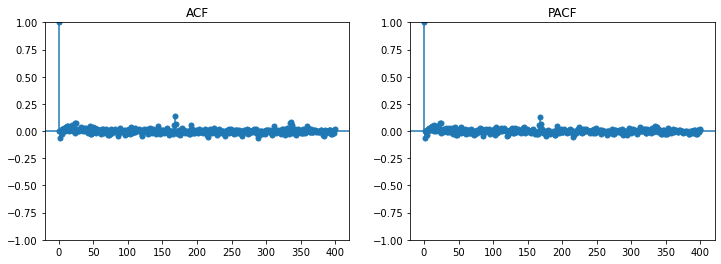

In [67]:
acf_pacf_plot(model3) 

In [68]:
pred_val_fourier = pd.DataFrame(model3.forecast(1705,exog = exog_to_test.values)).set_index(test.index)
pred_train_fourier  = model3.fittedvalues   

/var/folders/8m/q3zm_4mx7657khdxcx36bp4h0000gn/T/ipykernel_15785/2021560786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_viz['train_fitted'] = pred_train_fourier


<AxesSubplot:xlabel='Date_Hour'>

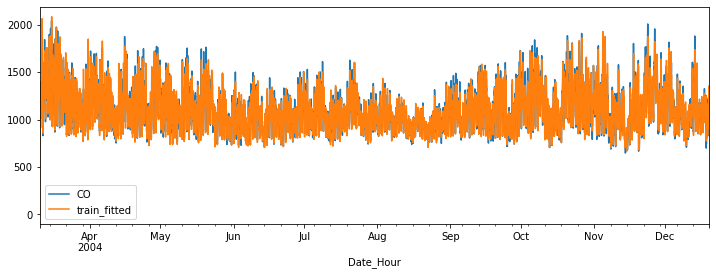

In [69]:
train_viz = train
train_viz['train_fitted'] = pred_train_fourier 
train_viz[['CO','train_fitted']].plot()

/var/folders/8m/q3zm_4mx7657khdxcx36bp4h0000gn/T/ipykernel_15785/2484313364.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_viz['test_fitted'] = pred_val_fourier


<AxesSubplot:xlabel='Date_Hour'>

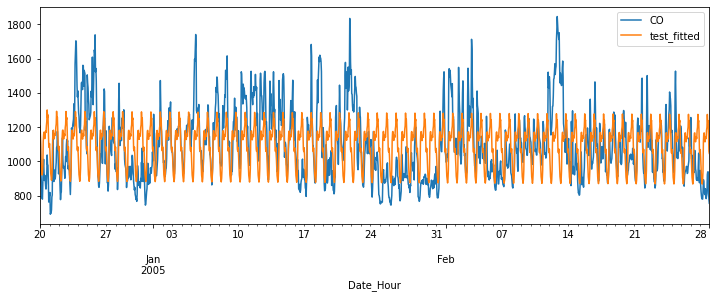

In [70]:
test_viz = test
test_viz['test_fitted'] = pred_val_fourier 
test_viz[['CO','test_fitted']].plot()

/var/folders/8m/q3zm_4mx7657khdxcx36bp4h0000gn/T/ipykernel_15785/297256772.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


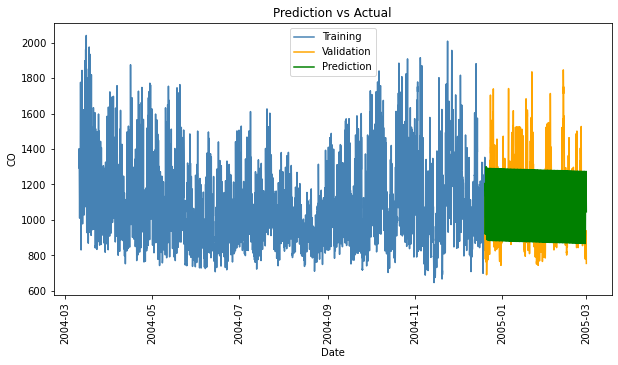

In [71]:
#grafico intero
fig=plt.figure(figsize=(10,5))
fig.show()
ax=fig.add_subplot(111)
plt.title('Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('CO')
plt.xticks(rotation=90)
ax.plot(train_viz['CO'], color='steelblue', label='Training')
#ax.plot(pred_mean_train[1:], color='red')
ax.plot(test_viz['CO'], color='orange', label='Validation')
ax.plot(test_viz['test_fitted'], color='green', label='Prediction')
plt.legend()
plt.show()

In [72]:
y_true_train_fourier= train_viz['CO']
y_pred_train_fourier= train_viz['train_fitted']
mae_fourier_train=mean_absolute_error(y_true_train_fourier , y_pred_train_fourier )
mape_train_fourier= mean_absolute_percentage_error(y_true_train_fourier , y_pred_train_fourier )
print('MAE_train: %f' % mean_absolute_error(y_true_train_fourier , y_pred_train_fourier ))
print('MAPE_train: %f' % mean_absolute_percentage_error(y_true_train_fourier , y_pred_train_fourier ))
y_true_test_fourier= test_viz['CO']
y_pred_test_fourier= test_viz['test_fitted']
mae_fourier_test=mean_absolute_error(y_true_test_fourier , y_pred_test_fourier )
mape_test_fourier=mean_absolute_percentage_error(y_true_test_fourier , y_pred_test_fourier )
print('MAE_test: %f'%  mean_absolute_error(y_true_test_fourier , y_pred_test_fourier ))
print('MAPE_test: %f' % mean_absolute_percentage_error(y_true_test_fourier , y_pred_test_fourier ))

MAE_train: 58.000000
MAPE_train: 5.167731
MAE_test: 149.200000
MAPE_test: 13.644492


#UCM

In [73]:
model_UC1 = sm.tsa.UnobservedComponents(train['CO'], 'lldtrend',cycle = True, seasonal=24,
                                        freq_seasonal=[{'period': 168, 'harmonics': 10}],
                                        exog = exog_to_train.values)  
                                                  
#fitting model to train data
model_UC1res = model_UC1.fit()
#fitting model to train data

model_UC1res .summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62722D+00    |proj g|=  4.51948D-03

At iterate    5    f=  6.05211D+00    |proj g|=  1.28025D-02

At iterate   10    f=  5.82260D+00    |proj g|=  6.60914D-03

At iterate   15    f=  5.81874D+00    |proj g|=  1.48111D-03

At iterate   20    f=  5.81837D+00    |proj g|=  2.10747D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     38      1     0     0   2.107D-06   5.818D+00
  F =   5.8183664034636164     

CONVERG

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Unobserved Components Results                                 
===============================================================================================
Dep. Variable:                                      CO   No. Observations:                 6821
Model:                local linear deterministic trend   Log Likelihood              -39687.077
                             + stochastic seasonal(24)   AIC                          79388.154
                   + stochastic freq_seasonal(168(10))   BIC                          79435.900
                                               + cycle   HQIC                         79404.634
Date:                                 Sun, 12 Jun 2022                                         
Time:                                         17:32:32                                         
Sample:                                     03-10-2004                                         
                                          - 12-19-2004                                         
Covariance Type:                                   opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
sigma2.irregular                 0.0006     63.119   8.93e-06      1.000    -123.710     123.711
sigma2.level                  6315.0394    141.448     44.646      0.000    6037.807    6592.272
sigma2.seasonal                 15.2397      1.523     10.005      0.000      12.254      18.225
sigma2.freq_seasonal_168(10)     0.0911      0.036      2.506      0.012       0.020       0.162
frequency.cycle               1.515e-24        nan        nan        nan         nan         nan
beta.x1                        237.8901   2481.742      0.096      0.924   -4626.235    5102.016
beta.x2                       -108.0002   1776.178     -0.061      0.952   -3589.246    3373.245
===================================================================================
Ljung-Box (L1) (Q):                  19.36   Jarque-Bera (JB):              1917.26
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.7e+25. Standard errors may be unstable.
"""

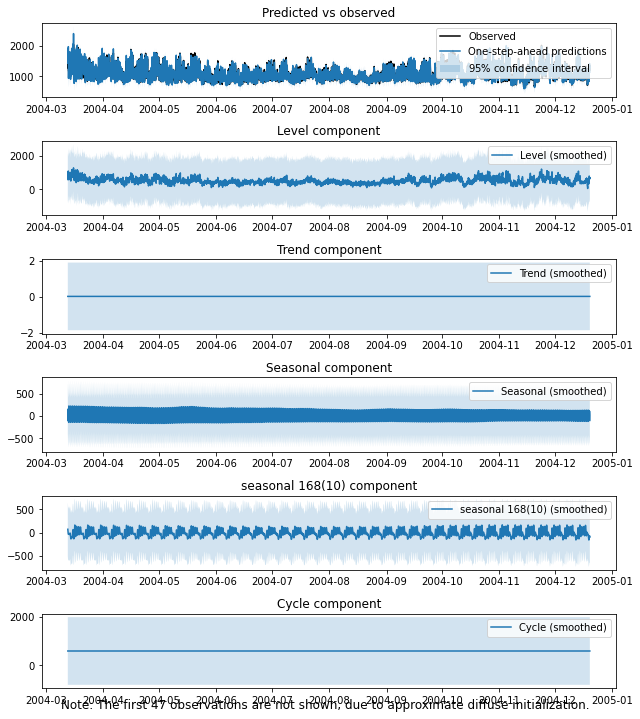

In [74]:
fig = model_UC1res.plot_components(figsize=(9, 10))
fig.tight_layout()

In [75]:
model_UC2 = sm.tsa.UnobservedComponents(train['CO'], 'rwdrift',cycle =True, seasonal=24,
                                        freq_seasonal=[{'period': 168, 'harmonics': 10}],
                                        exog = exog_to_train.values)  
                                                  
#fitting model to train data
model_UC2res = model_UC2.fit()
#fitting model to train data

model_UC2res .summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.58069D+00    |proj g|=  4.70289D-03

At iterate    5    f=  6.36316D+00    |proj g|=  1.12731D-02

At iterate   10    f=  5.81837D+00    |proj g|=  6.46425D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     27      1     0     0   6.464D-06   5.818D+00
  F =   5.8183726575793724     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Unobserved Components Results                                 
===============================================================================================
Dep. Variable:                                      CO   No. Observations:                 6821
Model:                          random walk with drift   Log Likelihood              -39687.120
                             + stochastic seasonal(24)   AIC                          79386.240
                   + stochastic freq_seasonal(168(10))   BIC                          79427.165
                                               + cycle   HQIC                         79400.365
Date:                                 Sun, 12 Jun 2022                                         
Time:                                         17:33:16                                         
Sample:                                     03-10-2004                                         
                                          - 12-19-2004                                         
Covariance Type:                                   opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
sigma2.level                  6312.2841     80.098     78.807      0.000    6155.295    6469.273
sigma2.seasonal                 15.2595      1.494     10.211      0.000      12.331      18.189
sigma2.freq_seasonal_168(10)     0.0912      0.036      2.527      0.012       0.020       0.162
frequency.cycle                  3.1416   3.74e-05   8.41e+04      0.000       3.142       3.142
beta.x1                        237.8891    361.238      0.659      0.510    -470.125     945.903
beta.x2                       -108.0011    667.141     -0.162      0.871   -1415.573    1199.571
===================================================================================
Ljung-Box (L1) (Q):                  19.42   Jarque-Bera (JB):              1919.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.89e+16. Standard errors may be unstable.
"""

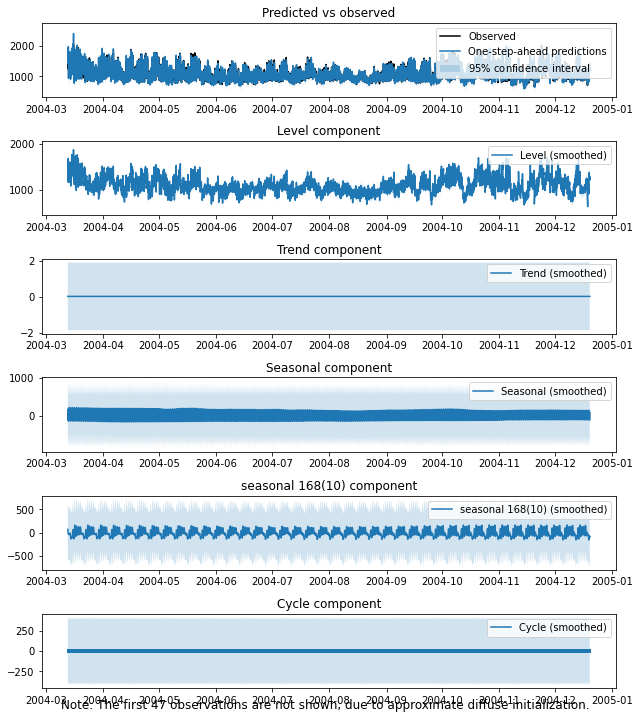

In [76]:
fig = model_UC2res.plot_components(figsize=(9, 10))
fig.tight_layout()

In [77]:
model_UC3 = sm.tsa.UnobservedComponents(train['CO'],'llevel',cycle =True, seasonal=24,
                                        freq_seasonal=[{'period': 168, 'harmonics': 10}],
                                        exog = exog_to_train.values)  
                                                  
#fitting model to train data
model_UC3res = model_UC3.fit()
#fitting model to train data

model_UC3res .summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62780D+00    |proj g|=  4.54131D-03


 This problem is unconstrained.



At iterate    5    f=  6.59193D+00    |proj g|=  5.91632D-03

At iterate   10    f=  5.84670D+00    |proj g|=  1.78616D-03

At iterate   15    f=  5.83189D+00    |proj g|=  9.13182D-03

At iterate   20    f=  5.81882D+00    |proj g|=  1.28201D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     40      1     0     0   4.579D-06   5.819D+00
  F =   5.8186913520873418     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Unobserved Components Results                                 
===============================================================================================
Dep. Variable:                                      CO   No. Observations:                 6821
Model:                                     local level   Log Likelihood              -39689.294
                             + stochastic seasonal(24)   AIC                          79392.587
                   + stochastic freq_seasonal(168(10))   BIC                          79440.334
                                               + cycle   HQIC                         79409.067
Date:                                 Sun, 12 Jun 2022                                         
Time:                                         17:34:24                                         
Sample:                                     03-10-2004                                         
                                          - 12-19-2004                                         
Covariance Type:                                   opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
sigma2.irregular                 0.0009     62.952   1.44e-05      1.000    -123.382     123.384
sigma2.level                  6313.6340    141.135     44.735      0.000    6037.015    6590.253
sigma2.seasonal                 15.2385      1.524     10.000      0.000      12.252      18.225
sigma2.freq_seasonal_168(10)     0.0913      0.036      2.508      0.012       0.020       0.163
frequency.cycle               2.513e-11   8459.228   2.97e-15      1.000   -1.66e+04    1.66e+04
beta.x1                        237.8878   2957.203      0.080      0.936   -5558.124    6033.900
beta.x2                       -108.0041   1594.503     -0.068      0.946   -3233.172    3017.163
===================================================================================
Ljung-Box (L1) (Q):                  19.45   Jarque-Bera (JB):              1907.71
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

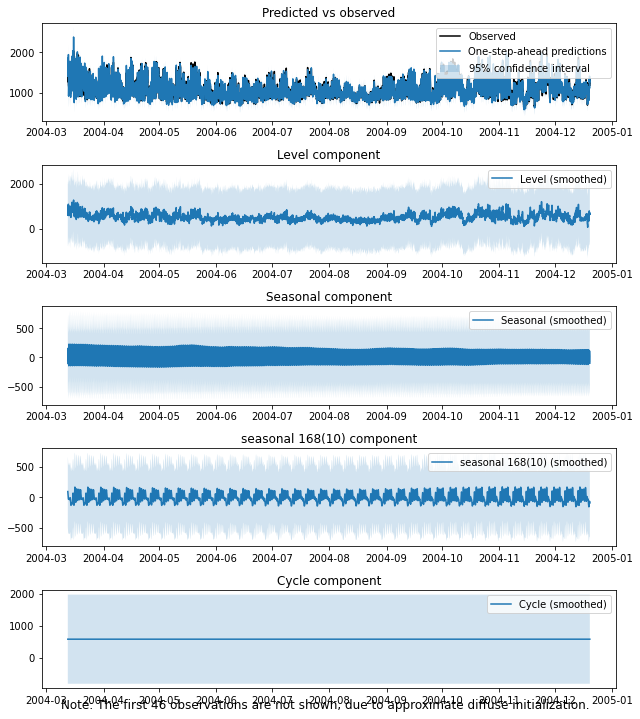

In [78]:
fig = model_UC3res.plot_components(figsize=(9, 10))
fig.tight_layout()

In [79]:
model_UC4 = sm.tsa.UnobservedComponents(train['CO'],'rwalk',cycle = True, seasonal=24,
                                        freq_seasonal=[{'period': 168, 'harmonics': 10}],
                                        exog = exog_to_train.values)  
                                                  
#fitting model to train data
model_UC4res = model_UC4.fit()
#fitting model to train data

model_UC4res .summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.58127D+00    |proj g|=  4.70334D-03


 This problem is unconstrained.



At iterate    5    f=  5.86202D+00    |proj g|=  1.23373D-02

At iterate   10    f=  5.81960D+00    |proj g|=  1.77140D-03

At iterate   15    f=  5.81885D+00    |proj g|=  8.36803D-04

At iterate   20    f=  5.81869D+00    |proj g|=  2.77439D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     46      1     0     0   5.994D-07   5.819D+00
  F =   5.8186886963095468     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Unobserved Components Results                                 
===============================================================================================
Dep. Variable:                                      CO   No. Observations:                 6821
Model:                                     random walk   Log Likelihood              -39689.276
                             + stochastic seasonal(24)   AIC                          79390.551
                   + stochastic freq_seasonal(168(10))   BIC                          79431.477
                                               + cycle   HQIC                         79404.677
Date:                                 Sun, 12 Jun 2022                                         
Time:                                         17:35:27                                         
Sample:                                     03-10-2004                                         
                                          - 12-19-2004                                         
Covariance Type:                                   opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
sigma2.level                  6312.9846     80.209     78.707      0.000    6155.778    6470.191
sigma2.seasonal                 15.2445      1.494     10.207      0.000      12.317      18.172
sigma2.freq_seasonal_168(10)     0.0913      0.036      2.527      0.012       0.020       0.162
frequency.cycle                  3.1416      0.000   2.06e+04      0.000       3.141       3.142
beta.x1                        237.8884   2729.577      0.087      0.931   -5111.985    5587.761
beta.x2                       -108.0018   1221.260     -0.088      0.930   -2501.628    2285.624
===================================================================================
Ljung-Box (L1) (Q):                  19.48   Jarque-Bera (JB):              1906.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
pred_val1 = pd.DataFrame(model_UC1res.forecast(1705, exog = exog_to_test.values)).set_index(test.index)
pred_train1 = model_UC1res.fittedvalues 
pred_val2 = pd.DataFrame(model_UC2res.forecast(1705, exog = exog_to_test.values)).set_index(test.index)
pred_train2 = model_UC2res.fittedvalues 
pred_val3 = pd.DataFrame(model_UC3res.forecast(1705, exog = exog_to_test.values)).set_index(test.index)
pred_train3 = model_UC3res.fittedvalues  
pred_val4 = pd.DataFrame(model_UC4res.forecast(1705, exog = exog_to_test.values)).set_index(test.index)
pred_train4 = model_UC4res.fittedvalues

In [81]:
mape_lltrend_test=mape_test(test, pred_val1)
mape_lltrend_train=mape_train(train['CO'], pred_train1)
mape_rwdrift_test=mape_test(test, pred_val2)
mape_rwdrift_train=mape_train(train['CO'], pred_train2)
mape_lleval_test=mape_test(test, pred_val3)
mape_lleval_train=mape_train(train['CO'], pred_train3)
mape_rwalk_test=mape_test(test, pred_val4)
mape_rwalk_train=mape_train(train['CO'], pred_train4)

In [82]:
def mae_test(test, pred):
    test, pred = np.array(test), np.array(pred)
    return np.mean(np.abs(test - pred))

In [83]:
def mae_train(train, pred):
    train, pred = np.array(train), np.array(pred)
    return np.mean(np.abs(train - pred))

In [84]:
mae_lltrend_test=mae_test(test, pred_val1)
mae_lltrend_train=mae_train(train['CO'], pred_train1)
mae_rwdrift_test=mae_test(test, pred_val2)
mae_rwdrift_train=mae_train(train['CO'], pred_train2)
mae_lleval_test=mae_test(test, pred_val3)
mae_lleval_train=mae_train(train['CO'], pred_train3)
mae_rwalk_test=mae_test(test, pred_val4)
mae_rwalk_train=mae_train(train['CO'], pred_train4)

In [85]:
table = pd.DataFrame({'train_mape': [mape_lltrend_train, mape_rwdrift_train, mape_lleval_train,mape_rwalk_train], 
                      'test_mape': [mape_lltrend_test, mape_rwdrift_test,mape_lleval_test,  mape_rwalk_test],
                     'train_mae': [mae_lltrend_train, mae_rwdrift_train, mae_lleval_train,mae_rwalk_train], 
                     'test_mae': [mae_lltrend_test, mae_rwdrift_test,mae_lleval_test,  mae_rwalk_test]},

                         index = ['LLTREND','RWDRIFT','LLEVAL','RW'])
table

,train_mape,test_mape,train_mae,test_mae
LLTREND,5.593247,20.839465,62.782886,216.799387
RWDRIFT,5.600248,20.915399,62.869201,217.588371
LLEVAL,5.603663,19.727187,62.931187,205.362375
RW,5.616263,19.773814,63.087404,205.847707


#MACHINE LEARNING


Possiamo quindi estrarre l'array NumPy dal dataframe e convertire i valori interi in valori in virgola mobile, che sono più adatti per la modellazione con una rete neurale.Gli LSTM sono sensibili alla scala dei dati di input, in particolare quando vengono utilizzate le funzioni di attivazione sigmoid (predefinito) o tanh. Può essere una buona pratica ridimensionare i dati nell'intervallo da 0 a 1, chiamato anche normalizzazione. Possiamo facilmente normalizzare il set di dati utilizzando la classe di preelaborazione MinMaxScaler dalla libreria scikit-learn

In [86]:

#Normalizzazione del dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df)

Dopo aver modellato i nostri dati e stimato l'abilità del nostro modello sul set di dati di addestramento, è necessario avere un'idea dell'abilità del modello su nuovi dati invisibili. Utilizzo la cross validation.

Con i dati delle serie temporali, la sequenza dei valori è importante. Un metodo semplice che possiamo utilizzare è dividere il set di dati ordinato in set di dati di training e test. Il codice seguente calcola l'indice dello split point e separa i dati nei dataset di addestramento con il 0.8% delle osservazioni che possiamo utilizzare per addestrare il nostro modello, lasciando il restante 0.2% per testare il modello.

In [87]:
# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

6820 1706


Ora possiamo definire una funzione per creare un nuovo set di dati, come descritto sopra.

La funzione accetta due argomenti: il set di dati, che è un array NumPy che vogliamo convertire in un set di dati, e look_back, che è il numero di passaggi temporali precedenti da utilizzare come variabili di input per prevedere il periodo di tempo successivo, in questo caso predefinito a 1.

Questa impostazione predefinita creerà un set di dati in cui X è il numero di passeggeri in un dato momento (t) e Y è il numero di passeggeri in un momento successivo (t + 1).

Può essere configurato e lo faremo costruendo un set di dati di forma diversa nella prossima sezione.

In [88]:

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

Usiamo questa funzione per preparare il training e testare i set di dati per la modellazione.

In [89]:
# reshape into X=t and Y=t+1
look_back = 168
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


La rete LSTM prevede che i dati di input (X) siano forniti con una struttura di matrice specifica sotto forma di: [campioni, fasi temporali, caratteristiche].

Attualmente, i nostri dati sono nella forma: [campioni, caratteristiche] e stiamo inquadrando il problema come un passo temporale per ogni campione. Possiamo trasformare il treno preparato e testare i dati di input nella struttura prevista usando numpy.reshape() come segue:

In [90]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [91]:
trainX.shape 
trainY.shape


(6651,)

Ora siamo pronti per progettare e adattare la nostra rete LSTM a questo problema.

La rete ha uno strato visibile con 1 input, uno strato nascosto con 4 blocchi o neuroni LSTM e uno strato di output che effettua una previsione di valore singolo. La funzione di attivazione sigmoidea predefinita viene utilizzata per i blocchi LSTM. La rete viene addestrata per 100 epoche e viene utilizzata una dimensione batch di 1

In [92]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'loss', patience = 2)

model = Sequential()
model.add(LSTM(256, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=32, verbose=1, callbacks = [early_stop])

2022-06-12 17:36:31.215251: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
208/208 [==============================] - 3s 4ms/step - loss: 0.0096
Epoch 2/20
208/208 [==============================] - 1s 3ms/step - loss: 0.0047
Epoch 3/20
208/208 [==============================] - 1s 3ms/step - loss: 0.0044
Epoch 4/20
208/208 [==============================] - 1s 3ms/step - loss: 0.0039
Epoch 5/20
208/208 [==============================] - 1s 3ms/step - loss: 0.0037
Epoch 6/20
208/208 [==============================] - 1s 3ms/step - loss: 0.0033
Epoch 7/20
208/208 [==============================] - 1s 4ms/step - loss: 0.0037
Epoch 8/20
208/208 [==============================] - 1s 4ms/step - loss: 0.0034


Una volta che il modello è adatto, possiamo stimare le prestazioni del modello sul training e testare i set di dati. Questo ci darà un punto di confronto per i nuovi modelli.
Si noti che invertiamo le previsioni prima di calcolare i punteggi di errore per garantire che le prestazioni siano riportate nelle stesse unità dei dati originali.

In [93]:
#Previsioni
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
#Previsioni scalate
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
#Calcolo MAE
mae_train_LSTM = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (mae_train_LSTM ))
mae_test_LSTM = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (mae_test_LSTM))

mape_train_LSTM =  MAPE(trainY[0], trainPredict[:,0])
mape_test_LSTM =   MAPE(testY[0], testPredict[:,0])
print('Train Score: %.2f MAPE' % (mape_train_LSTM))
print('Test Score: %.2f MAPE' % (mape_test_LSTM ))


Train Score: 58.90 MAE
Test Score: 61.30 MAE
Train Score: 5.19 MAPE
Test Score: 5.37 MAPE


Infine, possiamo generare previsioni utilizzando il modello sia per il train che per il set di dati di test per ottenere un'indicazione visiva dell'abilità del modello.



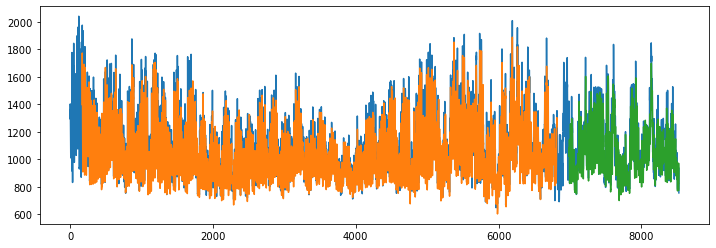

In [94]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Possiamo vedere che il modello ha svolto un ottimo lavoro adattando sia i set di dati di addestramento che quelli di test.

**GRU**

In [95]:
from keras.layers import GRU

In [96]:
# reshape into X=t and Y=t+1
look_back = 168
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)


In [97]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [98]:
trainX.shape 
trainY.shape


(6651,)

In [99]:

early_stop = EarlyStopping(monitor = 'loss', patience = 2)

model= Sequential()
model.add(GRU(256, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(trainX, trainY, epochs=15, batch_size=32, verbose=1, callbacks = [early_stop])



Epoch 1/15
208/208 [==============================] - 3s 3ms/step - loss: 0.0144
Epoch 2/15
208/208 [==============================] - 1s 2ms/step - loss: 0.0051
Epoch 3/15
208/208 [==============================] - 1s 3ms/step - loss: 0.0048
Epoch 4/15
208/208 [==============================] - 1s 3ms/step - loss: 0.0042
Epoch 5/15
208/208 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 6/15
208/208 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 7/15
208/208 [==============================] - 0s 2ms/step - loss: 0.0037
Epoch 8/15
208/208 [==============================] - 1s 3ms/step - loss: 0.0037
Epoch 9/15
208/208 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 10/15
208/208 [==============================] - 0s 2ms/step - loss: 0.0038
Epoch 11/15
208/208 [==============================] - 0s 2ms/step - loss: 0.0034


In [100]:
trainScore = MAPE(trainY[0], trainPredict[:,0])
  
testScore = MAPE(testY[0], testPredict[:,0])



In [101]:
#Previsioni
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
#Previsioni scalate
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
#Calcolo MAE
mae_train_GRU = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (mae_train_GRU ))
mae_test_GRU = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (mae_test_GRU))

mape_train_GRU =  MAPE(trainY[0], trainPredict[:,0])
mape_test_GRU =   MAPE(testY[0], testPredict[:,0])
print('Train Score: %.2f MAPE' % (mape_train_GRU))
print('Test Score: %.2f MAPE' % (mape_test_GRU ))


Train Score: 55.00 MAE
Test Score: 54.90 MAE
Train Score: 4.87 MAPE
Test Score: 4.87 MAPE


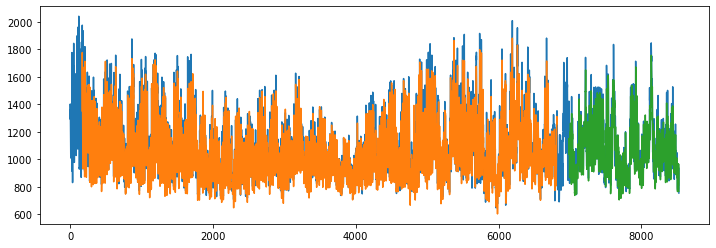

In [102]:
#Previsioni train per grafico
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
#Previsioni test per grafico
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
#Grafico intero
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [135]:
table = pd.DataFrame({'train_mae': [mae_train_SARIMAX,mae_fourier_train,mae_lleval_train,mae_train_LSTM,mae_train_GRU ], 
                          'test_mae': [mae_test_SARIMAX,mae_fourier_test,mae_lleval_test,mae_test_LSTM,mae_test_GRU ],
                          'train_mape': [mape_train_SARIMAX,mape_train_fourier,mape_lleval_train,mape_train_LSTM,mape_train_GRU], 
                          'test_mape': [mape_test_SARIMAX,mape_test_fourier,mape_lleval_test,mape_test_LSTM,mape_test_GRU]},
                     
                         
                           index = ['ARIMA','ARIMA_FOURIER','UCLM','LSTM','GRU'])
                        
table


,train_mae,test_mae,train_mape,test_mape
ARIMA,58.000000,149.200000,5.167733,13.644612
ARIMA_FOURIER,58.000000,149.200000,5.167731,13.644492
UCLM,62.931187,205.362375,5.603663,19.727187
LSTM,58.900000,61.300000,5.188175,5.366033
GRU,55.000000,54.900000,4.868371,4.874036


In [104]:
table.to_csv('model_878067_20220612.csv')

#Previsioni orarie dal 2005-03-01 al 2005-03-31

In [105]:
test_datetime = pd.date_range(start='2005-03-01-00:00:00', end='2005-03-31-23:00:00', freq ='H')
date_fourier = pd.date_range(start='2005-03-01-00:00:00', end='2005-03-31-23:00:00', freq ='H')

In [106]:
df_fourier = pd.DataFrame(index=date_fourier)
df_fourier

""
2005-03-01 00:00:00
2005-03-01 01:00:00
2005-03-01 02:00:00
2005-03-01 03:00:00
2005-03-01 04:00:00
...
2005-03-31 19:00:00
2005-03-31 20:00:00
2005-03-31 21:00:00
2005-03-31 22:00:00


In [108]:
#Creazione termini di Fourier
exogi = pd.DataFrame({'Date_Hour': df_fourier.index})
exogi = exogi.set_index(pd.PeriodIndex(exogi['Date_Hour'], freq='H'))
ex7=exogi['sin_week_2'] = np.sin(2 * np.pi * exogi.index.hour / 168) #24*7 settimanale
ex8=exogi['cos_week_2'] = np.cos(2 * np.pi * exogi.index.hour / 168) #24*7
#ex9=exog['sin_year_4'] = np.sin(4 * np.pi * exog.index.hour / 8766) #24*365.25 annuale
#ex10=exog['cos_year_4'] = np.cos(4 * np.pi * exog.index.hour / 8766)

exogi = exogi.drop(columns=['Date_Hour'])
exogi_to_train = exog[:len(df)]
exogi_to_test = exog['2005-03-01 00:00:00':]
print(exogi.shape)


print(exogi_to_train.shape)

(744, 2)
(8526, 4)


**ARIMA**

In [109]:
mod_pred = sm.tsa.statespace.SARIMAX(df['CO'], order=(2,1,1), seasonal_order=(1,1,1,24), exogi =exogi_to_train.values) 
results = mod_pred.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.87633D+00    |proj g|=  7.77544D-02


 This problem is unconstrained.



At iterate    5    f=  5.83501D+00    |proj g|=  1.89536D-02

At iterate   10    f=  5.82913D+00    |proj g|=  4.78002D-03

At iterate   15    f=  5.81856D+00    |proj g|=  1.73429D-02

At iterate   20    f=  5.78026D+00    |proj g|=  5.93491D-02

At iterate   25    f=  5.76297D+00    |proj g|=  8.80659D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     36      1     0     0   2.354D-05   5.763D+00
  F =   5.7628328987814488     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:        

In [110]:
pred_val_SARIMAX = results.forecast(744, exogi=exogi_to_test)
pred_val_SARIMAX

2005-03-01 00:00:00     793.670432
2005-03-01 01:00:00     785.894946
2005-03-01 02:00:00     770.008173
2005-03-01 03:00:00     767.212427
2005-03-01 04:00:00     769.863930
                          ...     
2005-03-31 19:00:00    1152.989555
2005-03-31 20:00:00    1172.641242
2005-03-31 21:00:00    1098.370507
2005-03-31 22:00:00    1046.435206
2005-03-31 23:00:00    1039.730270
Freq: H, Name: predicted_mean, Length: 744, dtype: float64

In [111]:
fitted_SARIMAX = pd.DataFrame(pred_val_SARIMAX).set_index(test_datetime)

/var/folders/8m/q3zm_4mx7657khdxcx36bp4h0000gn/T/ipykernel_15785/64295683.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


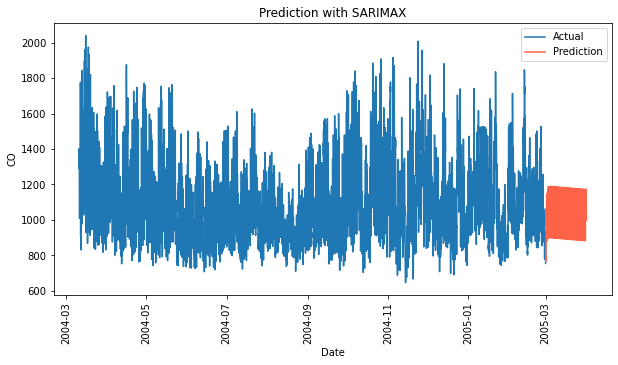

In [112]:
fig=plt.figure(figsize=(10,5))
fig.show()
ax=fig.add_subplot(111)


plt.title('Prediction with SARIMAX')
plt.xlabel('Date')
plt.ylabel('CO')
plt.xticks(rotation=90)
ax.plot(df, label='Actual')
ax.plot(fitted_SARIMAX, color='tomato', label='Prediction')
plt.legend()
plt.show()

In [113]:
fitted_SARIMAX .to_csv('ARIMA.csv')

In [114]:
fitted_SARIMAX['SARIMAX'] = fitted_SARIMAX

In [115]:
 fitted_SARIMAX.drop(columns=fitted_SARIMAX.columns[0],axis=1, inplace=True)

In [116]:
fitted_SARIMAX

,SARIMAX
2005-03-01 00:00:00,793.670432
2005-03-01 01:00:00,785.894946
2005-03-01 02:00:00,770.008173
2005-03-01 03:00:00,767.212427
2005-03-01 04:00:00,769.863930
...,...
2005-03-31 19:00:00,1152.989555
2005-03-31 20:00:00,1172.641242
2005-03-31 21:00:00,1098.370507
2005-03-31 22:00:00,1046.435206


**UCLM**

In [117]:
model_ucm_fin = sm.tsa.UnobservedComponents(df['CO'], 'llevel', cycle =True, seasonal=24,
                                        freq_seasonal=[{'period': 168, 'harmonics': 20}],
                                        exogi = exogi_to_train.values)  
                                                  
model_ucm_fin_fit = model_ucm_fin.fit(low_memory = True)
model_ucm_fin_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.21468D+00    |proj g|=  4.91356D-03


 This problem is unconstrained.



At iterate    5    f=  6.74076D+00    |proj g|=  3.04322D-03

At iterate   10    f=  5.88236D+00    |proj g|=  3.65088D-02

At iterate   15    f=  5.79568D+00    |proj g|=  2.02615D-03

At iterate   20    f=  5.77630D+00    |proj g|=  3.79529D-03

At iterate   25    f=  5.77547D+00    |proj g|=  4.07402D-05

At iterate   30    f=  5.77546D+00    |proj g|=  7.34478D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     59      1     0     0   3.678D-06   5.775D+00
  F =   5.7754629019499673     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Unobserved Components Results                                 
===============================================================================================
Dep. Variable:                                      CO   No. Observations:                 8526
Model:                                     local level   Log Likelihood              -49241.597
                             + stochastic seasonal(24)   AIC                          98493.193
                   + stochastic freq_seasonal(168(20))   BIC                          98528.409
                                               + cycle   HQIC                         98505.213
Date:                                 Sun, 12 Jun 2022                                         
Time:                                         17:44:09                                         
Sample:                                     03-10-2004                                         
                                          - 02-28-2005                                         
Covariance Type:                                approx                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
sigma2.irregular                 0.2604     84.892      0.003      0.998    -166.124     166.645
sigma2.level                  5794.0569    196.813     29.439      0.000    5408.311    6179.802
sigma2.seasonal                 11.9061      1.562      7.624      0.000       8.845      14.967
sigma2.freq_seasonal_168(20)     0.0220      0.009      2.545      0.011       0.005       0.039
frequency.cycle               3.227e-11      0.001   3.32e-08      1.000      -0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   2.19   Jarque-Bera (JB):              2874.97
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [118]:
pred_val_UCLM = model_ucm_fin_fit.forecast(744, exogi=exogi_to_test)

In [119]:
fitted_UCLM= pd.DataFrame(pred_val_UCLM ).set_index(test_datetime)

/var/folders/8m/q3zm_4mx7657khdxcx36bp4h0000gn/T/ipykernel_15785/4162555182.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


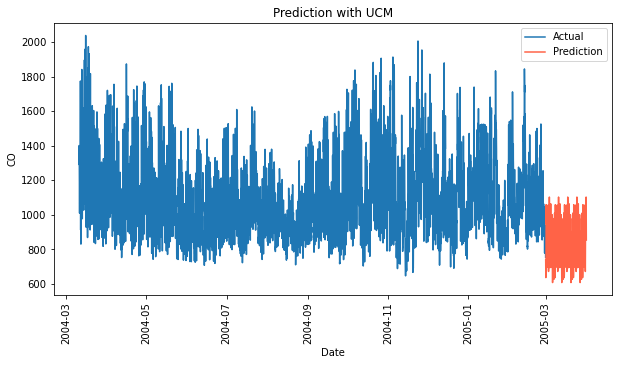

In [120]:
fig=plt.figure(figsize=(10,5))
fig.show()
ax=fig.add_subplot(111)


plt.title('Prediction with UCM')
plt.xlabel('Date')
plt.ylabel('CO')
plt.xticks(rotation=90)
ax.plot(df, label='Actual')
ax.plot(fitted_UCLM, color='tomato', label='Prediction')
plt.legend()
plt.show()

In [121]:
fitted_UCLM.to_csv('UCLM.csv')

In [122]:
fitted_UCLM['uclm'] = fitted_UCLM

In [123]:
fitted_UCLM.drop(columns=fitted_UCLM.columns[0],axis=1, inplace=True)

**ML**

In [124]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor = 'loss', patience = 2)

train = dataset
look_back = 168
trainX, trainY = create_dataset(train, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
model = Sequential()
model.add(GRU(256, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=15, batch_size=16, verbose=1, callbacks = [early_stop])

Epoch 1/15
523/523 [==============================] - 6s 3ms/step - loss: 0.0086
Epoch 2/15
523/523 [==============================] - 2s 3ms/step - loss: 0.0045
Epoch 3/15
523/523 [==============================] - 2s 3ms/step - loss: 0.0043
Epoch 4/15
523/523 [==============================] - 2s 3ms/step - loss: 0.0039
Epoch 5/15
523/523 [==============================] - 2s 3ms/step - loss: 0.0036
Epoch 6/15
523/523 [==============================] - 2s 3ms/step - loss: 0.0037
Epoch 7/15
523/523 [==============================] - 2s 3ms/step - loss: 0.0037


In [125]:
def predict(num_prediction, model): #funzione per la previsione ricorsiva delle RNN
    prediction_list = dataset[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, 1, look_back)) 
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

In [126]:
num_prediction = len(test_datetime)
forecast_ML = predict(num_prediction, model)

In [127]:
forecast_ML = scaler.inverse_transform(forecast_ML.reshape(-1,1)).flatten()
fitted_ML= pd.DataFrame(forecast_ML[0:744], index = test_datetime)

/var/folders/8m/q3zm_4mx7657khdxcx36bp4h0000gn/T/ipykernel_15785/2823734100.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


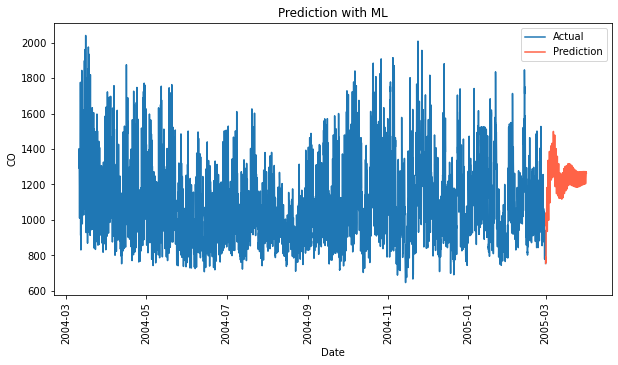

In [134]:
fig=plt.figure(figsize=(10,5))
fig.show()
ax=fig.add_subplot(111)


plt.title('Prediction with ML')
plt.xlabel('Date')
plt.ylabel('CO')
plt.xticks(rotation=90)
ax.plot(df, label='Actual')
ax.plot(fitted_ML, color='tomato', label='Prediction')
plt.legend()
plt.show()

In [129]:
fitted_ML.to_csv('ML.csv')

In [130]:
fitted_ML['ML'] = fitted_ML


In [131]:
fitted_ML.drop(columns=fitted_ML.columns[0],axis=1, inplace=True)

In [132]:
test_data = pd.DataFrame(test_datetime, index=test_datetime)
final_prediction= pd.concat([test_data, fitted_ML, 
                                   fitted_UCLM, 
                                   fitted_SARIMAX],axis=1)

final_prediction.columns = ['Data','ARIMA', 'UCM', 'ML']
final_prediction =final_prediction.reset_index().drop('index', axis=1)
final_prediction

,Data,ARIMA,UCM,ML
0,2005-03-01 00:00:00,755.000000,740.099328,793.670432
1,2005-03-01 01:00:00,790.237966,686.591961,785.894946
2,2005-03-01 02:00:00,783.811428,643.911856,770.008173
3,2005-03-01 03:00:00,768.492611,636.716183,767.212427
4,2005-03-01 04:00:00,768.006609,644.285111,769.863930
...,...,...,...,...
739,2005-03-31 19:00:00,1263.637757,1103.504733,1152.989555
740,2005-03-31 20:00:00,1270.423905,1101.413261,1172.641242
741,2005-03-31 21:00:00,1272.280357,973.671987,1098.370507
742,2005-03-31 22:00:00,1269.178425,896.435753,1046.435206


In [133]:
final_prediction.to_csv('878067_20220612.csv')